## 1. User Input

In [1]:
%load_ext autoreload
%autoreload 2
api_key = "api"
rh_user = "user"
rh_pass = "pass"
demo_run = True

## 2. Downloading Robinhood orders
It will prompt MFA (if you have it enabled). Run again if you want refreshed Robinhood data.

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pyrh import Robinhood
if not demo_run:
    client = Robinhood(username=rh_user, password=rh_pass)
    client.login()
else:
    client = None

In [4]:
from backend.robinhood_data import RobinhoodData
rh = RobinhoodData('data/', client)
if demo_run:
    demo_orders = rh.demo_orders()
    demo_dividends= rh.demo_dividends()
else:
    demo_orders = None
    demo_dividends= None
dividends, orders, open_positions, closed_positions = rh.download(demo_orders, demo_dividends)

## 3. Download stock prices and market index
Rerun if you want fresh market data

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from backend.market_data import download_save_market_data

market = download_save_market_data(
    api_key=api_key,
    symbols=orders.symbol.unique(),
    start_date=orders.date.min(),
    end_date=pd.Timestamp("today", tz='UTC'))

## 4. Portfolio Models

In [6]:
from backend.portfolio_model import PortfolioModels
import empyrical as emp

In [7]:
# main calculations section
ptf = PortfolioModels('data')
summary = ptf.portfolio_summary()
stocks = ptf.stocks_risk()
df_corr, df_cov = ptf.stocks_correlation()
ptf_stats = ptf.portfolio_stats()
markowitz = ptf.markowitz_portfolios()
investment, dividends = ptf.portfolio_returns()

## 5. Results

### 5.1 Portfolio summary

In [8]:
summary

,Shares,Portfolio weight,Current cost basis,Current value,Realized P/L,Dividends,Unrealized P/L,Total return,Total return rate
symbol,,,,,,,,,
AAPL,100,27.11%,"10,000.00","30,771.00",0.00,30.00,"20,771.00","20,801.00",208.01%
BA,100,10.57%,"10,000.00","12,000.00",0.00,80.00,"2,000.00","2,080.00",20.80%
BAC,100,1.89%,"10,000.00","2,144.00",0.00,100.00,"-7,856.00","-7,756.00",-77.56%
BND,100,7.70%,"10,000.00","8,735.00",0.00,60.00,"-1,265.00","-1,205.00",-12.05%
CAT,100,9.51%,"10,000.00","10,792.00",0.00,70.00,792.00,862.00,8.62%
CVX,100,7.86%,"10,000.00","8,916.00",0.00,40.00,"-1,084.00","-1,044.00",-10.44%
JPM,100,7.57%,"10,000.00","8,590.00",0.00,110.00,"-1,410.00","-1,300.00",-13.00%
MSFT,80,12.91%,"8,000.00","14,652.80",400.00,20.00,"6,652.80","7,072.80",88.41%
SPY,0,0.00%,0.00,0.00,0.00,0.00,0.00,0.00,-13.00%


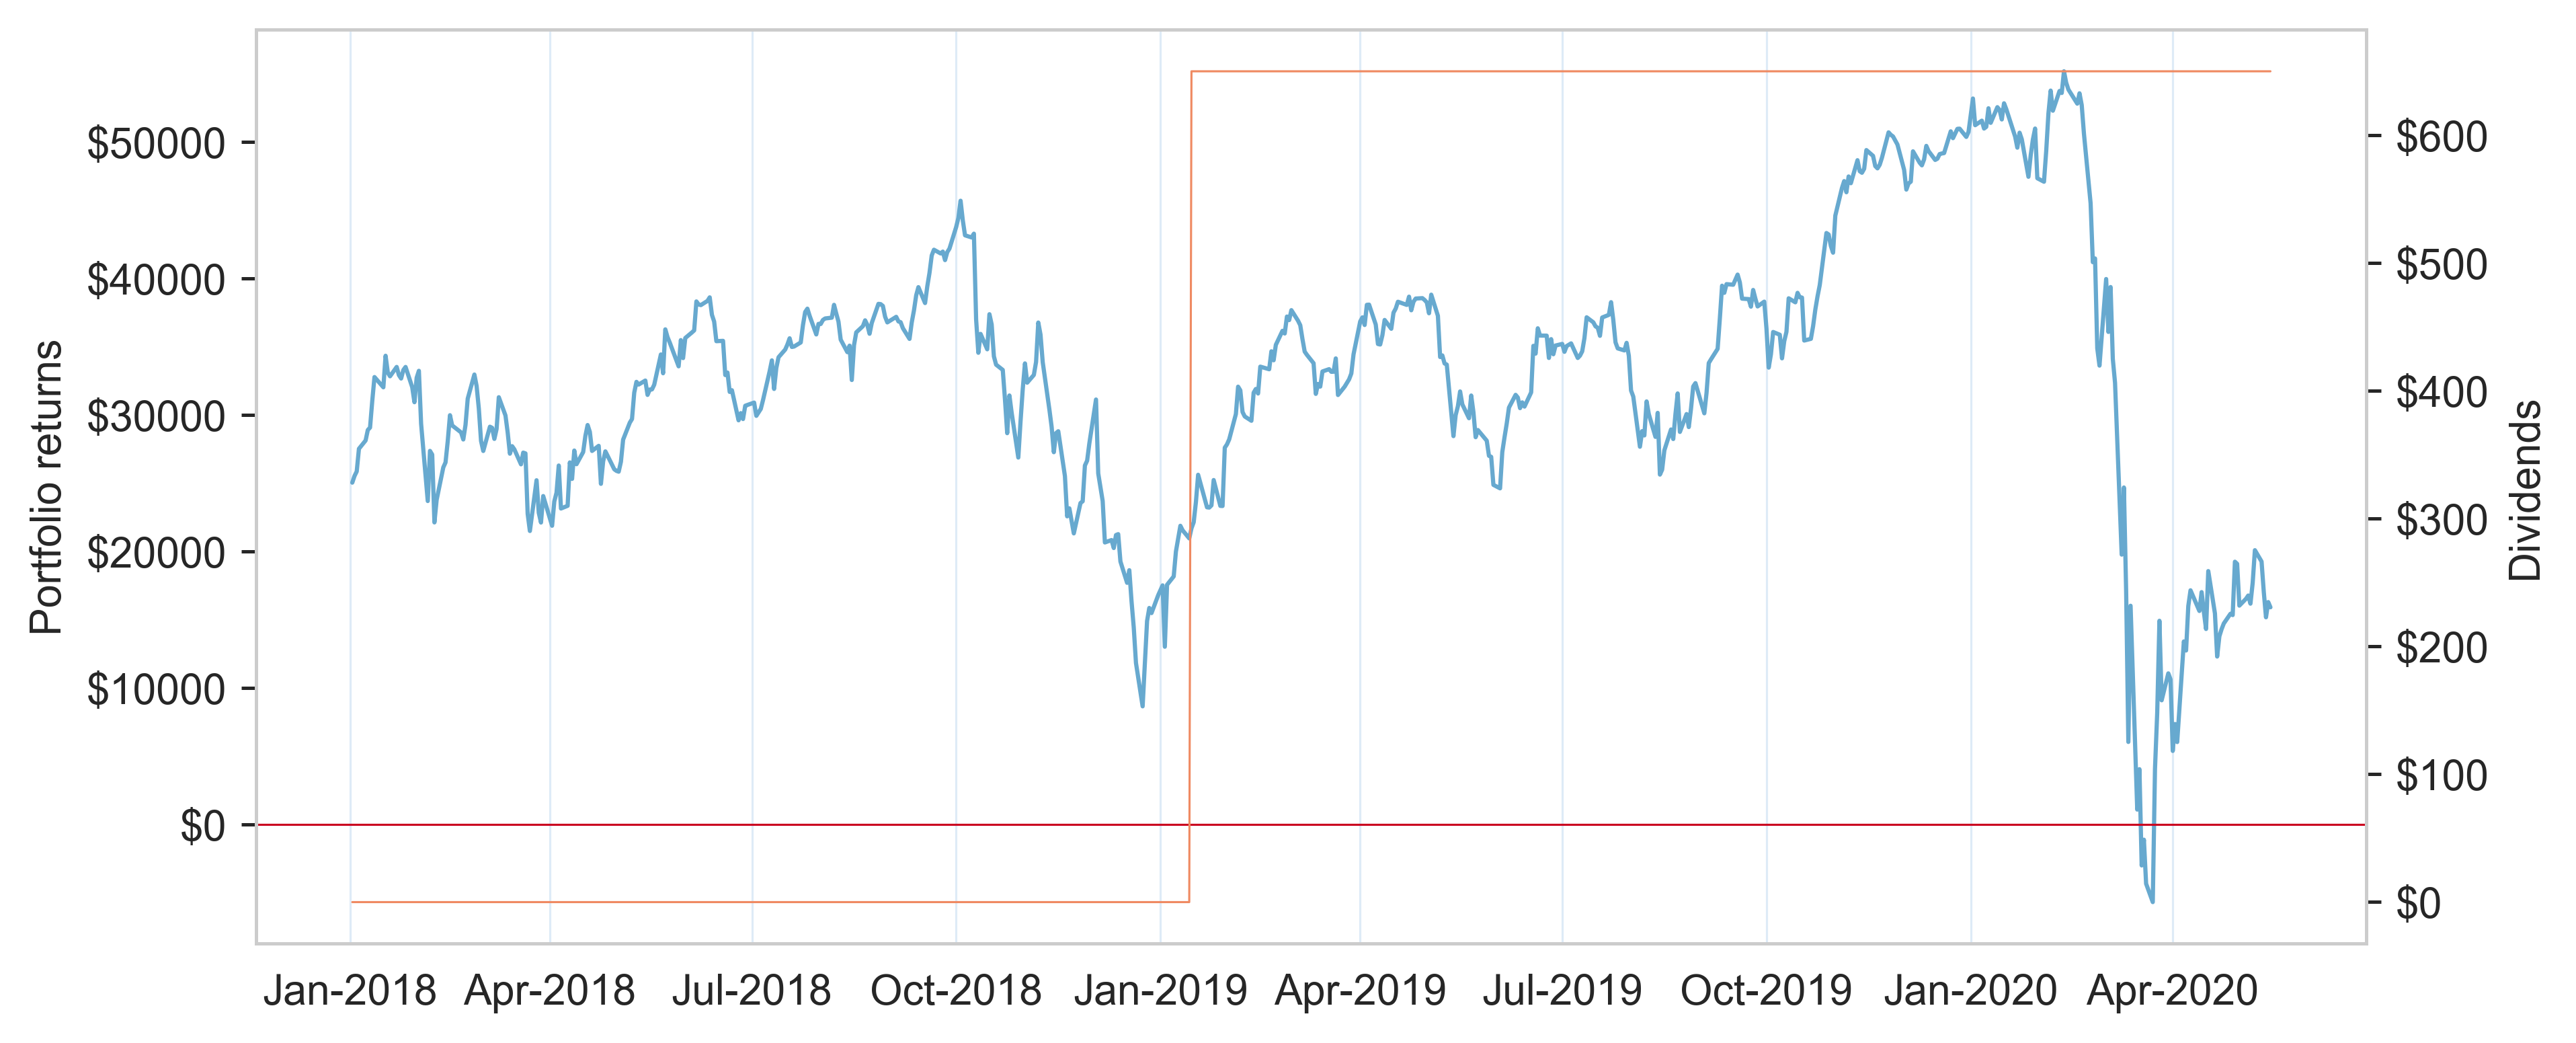

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
sns.set_style("whitegrid")
MY_DPI = 450

f, ax1 = plt.subplots(figsize=(9, 4), dpi=MY_DPI)
ax2 = ax1.twinx()

ax1.plot(investment, linewidth=1, color='#67a9cf')
ax1.axhline(y=0, color='#ca0020', linestyle='-', linewidth=0.5)
ax1.set_ylabel("Portfolio returns")

ax2.plot(dividends, linewidth=0.5, color='#ef8a62')
ax2.set_ylabel("Dividends")

# format y-axis
ax1.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: '${:.0f}'.format(x)))

ax2.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: '${:.0f}'.format(x)))

# format dates and grids
date_fmt = mdates.DateFormatter('%b-%Y')
ax1.xaxis.set_major_formatter(date_fmt)

ax1.grid(False, axis='both', linestyle='-', linewidth=0.5, color="#deebf7")
ax1.grid(b=None, axis='y')

ax2.grid(False, axis='both', linestyle='-', linewidth=0.5, color="#deebf7")
ax2.grid(b=None, axis='y')

plt.show()

### 5.2 Portfolio Stats

In [10]:
ptf_stats

Total return            0.168896
Market return           0.065149
Annual return          -0.093779
Annual volatility       0.333910
Sharpe ratio           -0.125034
Calmar ratio           -0.191382
Stability               0.021430
Max drawdown           -0.490007
Omega ratio             0.976127
Sortino ratio          -0.162470
Skew                   -1.116785
Kurtosis               10.173013
Tail ratio              0.810519
Daily value at risk    -0.031523
Alpha                  -0.074201
Beta                    1.284951
dtype: float64

### 5.3 Stocks performance

In [11]:
stocks

,Annual return,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk,Alpha,Beta
symbol,,,,,,,,,,,,,,
AAPL,0.132758,0.346394,0.535089,0.316011,0.273232,-0.420107,1.107361,0.728888,-0.758759,7.844976,0.962742,-0.032213,0.206838,1.189077
BA,-0.498785,0.550384,-0.960654,-0.584050,0.326022,-0.854010,0.805821,-1.188470,-1.941058,22.281448,0.768395,-0.046083,-0.408820,1.590952
BAC,-0.249847,0.382602,-0.556282,-0.435702,0.292356,-0.573437,0.890280,-0.726725,-0.816411,14.663461,0.727730,-0.039864,-0.189280,1.349874
BND,0.026054,0.066110,0.422406,0.288605,0.711001,-0.090277,1.115589,0.547675,-3.299764,79.912412,1.022690,-0.003482,0.028398,0.034370
CAT,-0.252920,0.364598,-0.613773,-0.431974,0.692017,-0.585500,0.894663,-0.783893,-1.033638,6.394100,0.828791,-0.038204,-0.198492,1.143169
CVX,-0.273736,0.407718,-0.566859,-0.392440,0.399302,-0.697524,0.873068,-0.703006,-2.876665,39.200329,0.971891,-0.029280,-0.204155,1.254108
JPM,-0.197678,0.351133,-0.448146,-0.383254,0.086644,-0.515789,0.908689,-0.585600,-0.985166,16.999535,0.856554,-0.030710,-0.143232,1.231032
MSFT,0.233092,0.330735,0.800994,0.672004,0.824493,-0.346862,1.168590,1.114466,-0.758147,12.174679,0.902879,-0.031262,0.306766,1.214808
SPY,-0.031499,0.242108,-0.009455,-0.082486,0.018364,-0.381868,0.997938,-0.012258,-1.309817,15.815873,0.678370,-0.022993,0.000000,1.000000


### 5.4 Correlations

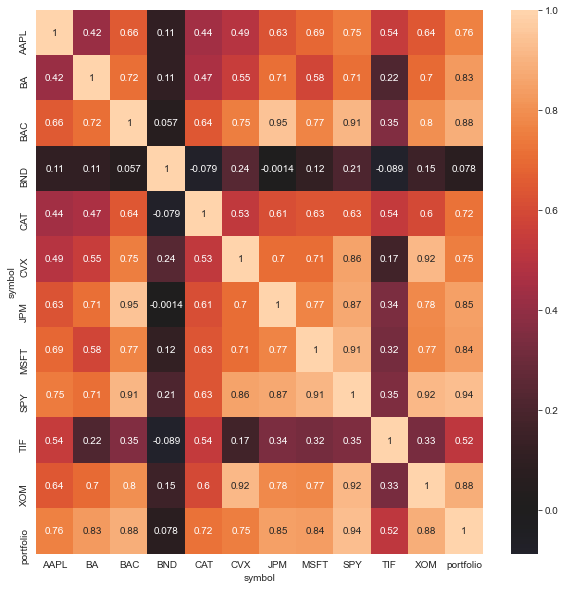

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ax=ax, data=df_corr, center=0, annot=True)

### 5.5 Markowitz

In [13]:
for l in markowitz:
    print(l['name'])
    print(l['weights'])
    print('\n')

Minimum variance portfolio
symbol
AAPL    1.339582e-09
BA      1.026861e-09
BAC     1.784649e-09
BND     9.733293e-01
CAT     1.901005e-02
CVX     6.861165e-10
JPM     2.583200e-05
MSFT    3.161649e-09
TIF     7.634780e-03
XOM     9.630994e-10
dtype: float64


Target: more than 50% of stock returns
symbol
AAPL    1.217656e-09
BA      9.334000e-10
BAC     1.622235e-09
BND     9.733293e-01
CAT     1.901004e-02
CVX     6.236653e-10
JPM     2.585603e-05
MSFT    2.873919e-09
TIF     7.634780e-03
XOM     8.754388e-10
dtype: float64


Target: more than 75% of stock returns
symbol
AAPL    3.893516e-11
BA      3.104014e-11
BAC     5.996229e-11
BND     9.747411e-01
CAT     1.685827e-02
CVX     1.896378e-11
JPM     3.961909e-07
MSFT    1.209655e-10
TIF     8.400190e-03
XOM     2.767237e-11
dtype: float64


Target: more than 90% of stock returns
symbol
AAPL    1.058750e-08
BA      9.349044e-10
BAC     1.482497e-09
BND     3.021559e-01
CAT     8.659942e-10
CVX     1.476281e-09
JPM     1.890814e-09
